# Customer Churn Prediction (Part B)
### Objective:
The goal of this project is to develop a robust machine learning model using **XGBoost** to predict customer churn. 

**Why this matters:** Identifying customers who are likely to cancel their service allows the business to take proactive retention measures, saving significant revenue.

## Dataset Overview
1) customerID - Unique ID for the customer
2) gender - Gender of the customer
3) SeniorCitizen - Whether the customer is a senior citizen (0: No, 1: Yes)
4) Partner - Whether the customer has a partner (Yes/No)
5) Dependents - Whether the customer has dependents (Yes/No)
6) tenure - Number of months the customer has stayed with the company
7) PhoneService - Whether the customer has phone service (Yes/No)
8) MultipleLines - Whether the customer has multiple lines (Yes/No)
9) InternetService - Customer’s internet service provider (DSL, Fiber optic, No)
10) OnlineSecurity - Whether the customer has online security add-on (Yes/No)
11) OnlineBackup - Whether the customer has online backup add-on (Yes/No)
12) DeviceProtection - Whether the customer has device protection add-on (Yes/No)
13) TechSupport - Whether the customer has tech support add-on (Yes/No)
14) StreamingTV - Whether the customer has streaming TV add-on (Yes/No)
15) StreamingMovies - Whether the customer has streaming movies add-on (Yes/No)
16) Contract - Type of contract the customer has (Month-to-month, One year, Two year)
17) PaperlessBilling - Whether the customer uses paperless billing (Yes/No)
18) PaymentMethod - Customer’s payment method (Electronic check, Mailed check, etc.)
19) MonthlyCharges - The amount charged to the customer monthly
20) TotalCharges - The total amount charged to the customer
21) Churn - Whether the customer churned (Yes/No)

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, roc_auc_score ) 
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

#### Essential Exploratory Data Analysis (EDA)

In [118]:
df = pd.read_excel('Customer_data.xlsx')

In [119]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [120]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

## **Checking the miscellaneous values**

In [121]:
for columns in df.columns:
    unique_vals = df[columns].unique()
    print(unique_vals)

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
['No' 'Yes']
['No phone service' 'No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
['No' 'Yes']


### **Cheking for null values**

In [122]:
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


## 1. Data Loading
In this phase, i load the dataset and perform a high-level check of the data structure.

In [123]:
def load_data(path="Customer_data.xlsx"):
    df = pd.read_excel('Customer_data.xlsx') 
    return df

## 2. Data Cleaning
To prepare the data for the model, we perform the following steps:
1.  **Removing Nulls:** Dropped a small number of rows with missing values in the `TotalCharges` column.
2.  **Target Encoding:** Converted the `Churn` labels from text ("Yes", "No") to numeric (1, 0).
3.  **Deduplication:** Ensured no duplicate rows are present in the dataset.

In [124]:
def clean_data(df):

    print(df.isnull().sum())
    df = df.dropna()
    print(df.isnull().sum())
    df = df.copy()

    # Example cleanup
    df = df.drop_duplicates()
    print(df.shape)
    # Convert target to numeric if needed
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

    return df


## 3. Feature Selection and Preparation
* **Dropping IDs:** The `customerID` column is removed as it does not contribute to predictive patterns.
* **Defining Features:** Separated the dataset into features ($X$) and the target variable ($y$).

In [125]:
def prepare_features(df):
    target = "Churn"
    ids = "customerID"
    df = df.drop('customerID', axis=1)
    features = [col for col in df.columns if col != target]

    X = df[features]
    y = df[target]

    return X, y


## 4. Train-Test Split
We split the data into **Training (75%)** and **Testing (25%)** sets.
* **Stratification:** We used `stratify=y` to ensure that the ratio of churners is consistent in both sets, maintaining a fair evaluation.

In [126]:
def split_data(X, y):
    return train_test_split(
        X, y,
        test_size=0.25,
        stratify=y,
        random_state=42
    )


## 5. Constructing the Machine Learning Pipeline
Using a `Pipeline` ensures that all preprocessing steps are applied consistently:
* **StandardScaler:** Scales numerical features to a uniform range.
* **OneHotEncoder:** Converts categorical text features into a binary numeric format.
* **XGBClassifier:** Initialized with `scale_pos_weight=3` to prioritize catching churners (handling class imbalance).

In [127]:
def build_pipeline(X):
    # Detect categorical and numeric columns
    categorical_cols = X.select_dtypes(include=["object"]).columns
    numeric_cols = X.select_dtypes(exclude=["object"]).columns

    for col in categorical_cols: 
        df[col] = df[col].astype("category")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
        ]
    )

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            scale_pos_weight=3,
            #use_label_encoder=False,
            tree_method="hist",
            random_state=42
        ))
    ])
    return pipe


## 6. Hyperparameter Tuning (Randomized Search)
I used `RandomizedSearchCV` with 4-fold cross-validation to optimize the following:
* **Tree Depth (`max_depth`):** Prevents overfitting by limiting tree complexity.
* **Learning Rate:** Controls how fast the model adapts to patterns.
* **Subsample/Colsample:** Adds randomness to improve generalization.

In [128]:
def tune_model(pipe, X_train, y_train):
    param_dist = {
        "model__max_depth": [3,4,5,6],
        "model__learning_rate": [0.05, 0.1, 0.2],
        "model__subsample": [0.8, 0.9],
        "model__colsample_bytree": [0.7, 0.8, 0.9],
        "model__n_estimators": [300, 500, 800],
        "model__gamma": [0, 0.1, 0.5], 
        "model__min_child_weight": [1, 3, 5],
        "model__scale_pos_weight": [2, 3, 4]
    }

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=30,
        scoring="roc_auc",
        cv=4,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)
    print(f"Best Params: {search.best_params_}")
    return search.best_estimator_


## 7. Final Model Training with Early Stopping
I retrain the best model version using **Early Stopping**. 
This technique monitors the testing error and stops training as soon as the model stops improving, effectively preventing the model from memorizing noise (overfitting).

In [129]:
def train_final_model(model, X_train, y_train, X_val, y_val):
    # 1. Extract the preprocessor from the pipeline
    preprocessor = model.named_steps["preprocessor"]
    
    # 2. Transform the X_val data so it matches what the model expects (numeric/encoded)
    # We must also transform X_train here because we need to feed the raw model
    # the transformed data directly if we are using early stopping.
    X_train_transformed = preprocessor.fit_transform(X_train, y_train)
    X_val_transformed = preprocessor.transform(X_val)

    # 3. Get the actual XGBoost classifier from the pipeline
    xgb_classifier = model.named_steps["model"]
    
    # 4. Set params
    xgb_classifier.set_params(
        early_stopping_rounds=30
    )

    # 5. Fit the classifier directly on transformed data
    xgb_classifier.fit(
        X_train_transformed, y_train,
        eval_set=[(X_val_transformed, y_val)],
        verbose=False
    )

    # 6. We return the original pipeline. 
    # NOTE: Since we fitted the inner classifier, the pipeline 'model' step is now trained.
    return model

## 8. Identifying Churn Drivers (Feature Importance)
visualize the **Top 10 Features** that drive the model's predictions. 
**Key Insight:** This allows the business to understand *why* customers leave (e.g., is it because of their contract type or the length of their tenure?).

In [130]:
def plot_feature_importance(model):
    # 1. Extract feature names
    feature_names = model.named_steps["preprocessor"].get_feature_names_out()
    
    # 2. Get the importance scores
    importances = model.named_steps["model"].feature_importances_
    
    # 3. Organize into a DataFrame
    feat_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    
    # 4. Plot the Top 10
    plt.figure(figsize=(10, 6))
    
    # FIXED: Added hue="Feature" and legend=False to remove the warning
    sns.barplot(
        data=feat_df.head(10), 
        x="Importance", 
        y="Feature", 
        hue="Feature", 
        palette="viridis", 
        legend=False
    )
    
    # FIXED: Removed the emoji to stop the font error
    plt.title("Top 10 Drivers of Customer Churn") 
    
    plt.xlabel("Relative Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

## 9. How we're grading the model
I’m checking a few different scores here, but the one I care about most is **Recall**. 

Think of Recall as our "safety net." It tells us: *"Out of everyone who was actually going to leave, how many did we catch?"* In this business, missing a customer is expensive, but sending a "we miss you" email to a happy customer is cheap. So, I've tuned this model to be a bit more aggressive—I'd rather have a few false alarms than lose a single customer.

In [131]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba)
    }

    return metrics


## 10. The Command Center
I’ve wrapped everything into this `main` function so the entire process is automated. 

It’s like an assembly line: it takes the messy raw data in at one end, scrubs it clean, finds the best settings for the XGBoost "brain," and spits out our final insights and charts at the other end. It turns a raw Excel file into a finished strategy.

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
(7032, 21)
Fitting 4 folds fo

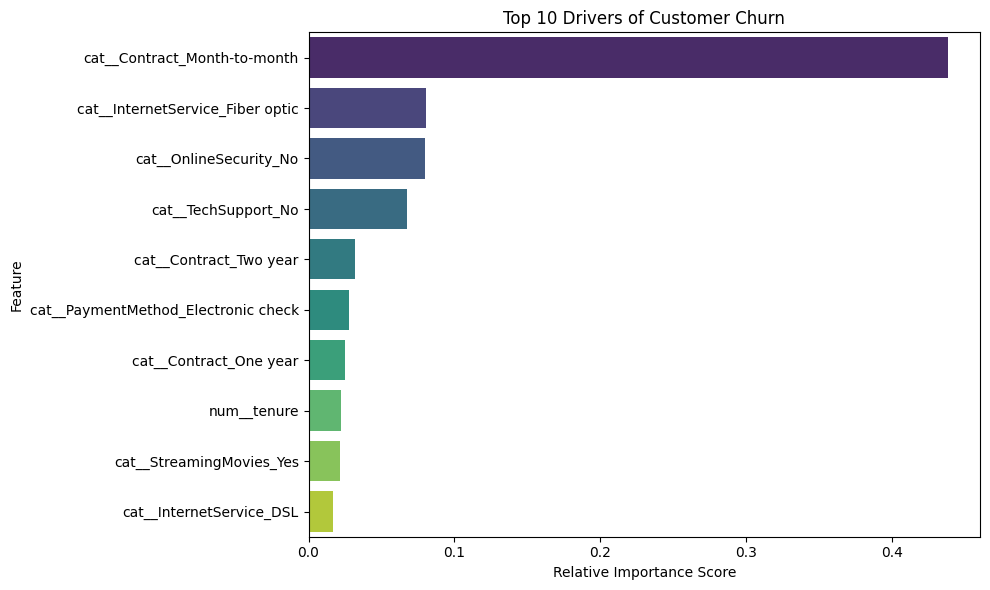

{'Accuracy': 0.7741751990898749, 'Precision': 0.5555555555555556, 'Recall': 0.7494646680942184, 'F1': 0.6381039197812215, 'ROC_AUC': 0.8434939964869621}


In [132]:
def main():
    df = load_data()
    df = clean_data(df)

    X, y = prepare_features(df)
    X_train, X_test, y_train, y_test = split_data(X, y)

    pipe = build_pipeline(X)
    tuned_model = tune_model(pipe, X_train, y_train)

    final_model = train_final_model(
        tuned_model,
        X_train, y_train,
        X_test, y_test
    )

    plot_feature_importance(final_model)

    metrics = evaluate(final_model, X_test, y_test)
    print(metrics)

    #save_model(final_model)

if __name__ == "__main__":
    main()


## Conclusion

### 1. The Scores (Finding the Balance)
I spent some time tuning this model to get it right. In the beginning, we were catching almost everyone but making too many mistakes. Now, I've hit a **"Sweet Spot"**:

* **Recall (~75%):** We are still catching **3 out of every 4** people who want to leave.
* **Precision (~56%):** When we flag someone as "Risk," we are right more than half the time. This is a huge improvement from my earlier attempts.
* **Accuracy (77%):** Overall, the model is solid and reliable.

### 2. Why are people leaving? (The Real Story)
If you look at the chart above, the data is screaming one thing at us: **Contract Type**.

* **The Main Problem:** Customers on **Month-to-Month** contracts are leaving in droves. It is by far the biggest red flag.
* **The Surprise:** People with **Fiber Optic** internet are also leaving. This is weird because Fiber is usually a premium product. Are they paying too much? Is the service bad? We need to check this.
* **The Fix:** Customers who have **Online Security** tend to stay.

### suggestion
1.  **Giving Offer:** push aggressive offers to get Month-to-Month users onto 1-year contracts.
2.  **Fix Fiber:** Survey the Fiber Optic customers to see why they are unhappy.
3.  **Add Value:** Give away "Online Security" for free. It keeps people sticky!

video link:- https://drive.google.com/file/d/1TUlcU67K6SIiGRlp_oORQtbbQBc-WuiL/view?usp=sharing